<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Spectral-analysis---why-should-we-care?" data-toc-modified-id="Spectral-analysis---why-should-we-care?-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Spectral analysis - why should we care?</a></span></li><li><span><a href="#The-Fourier-transform-in-2d" data-toc-modified-id="The-Fourier-transform-in-2d-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>The Fourier transform in 2d</a></span><ul class="toc-item"><li><span><a href="#Going-from-time-to-1d-space" data-toc-modified-id="Going-from-time-to-1d-space-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Going from time to 1d space</a></span></li><li><span><a href="#Fourier-transform-in-1d-space" data-toc-modified-id="Fourier-transform-in-1d-space-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Fourier transform in 1d-space</a></span></li><li><span><a href="#2d-gratings---It's-all-about-orientation" data-toc-modified-id="2d-gratings---It's-all-about-orientation-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>2d gratings - It's all about orientation</a></span></li><li><span><a href="#2d-Fourier-transform-of-oriented-gratings" data-toc-modified-id="2d-Fourier-transform-of-oriented-gratings-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>2d Fourier transform of oriented gratings</a></span></li><li><span><a href="#Decoding-frequency-and-orientation-from-amplitude-spectrum" data-toc-modified-id="Decoding-frequency-and-orientation-from-amplitude-spectrum-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Decoding frequency and orientation from amplitude spectrum</a></span></li><li><span><a href="#Reducing-dimensionality---from-2d-back-to-1d" data-toc-modified-id="Reducing-dimensionality---from-2d-back-to-1d-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Reducing dimensionality - from 2d back to 1d</a></span><ul class="toc-item"><li><span><a href="#Using-cut-throughs" data-toc-modified-id="Using-cut-throughs-2.6.1"><span class="toc-item-num">2.6.1&nbsp;&nbsp;</span>Using cut-throughs</a></span></li><li><span><a href="#Using-radial-averaging-/-radial-summing" data-toc-modified-id="Using-radial-averaging-/-radial-summing-2.6.2"><span class="toc-item-num">2.6.2&nbsp;&nbsp;</span>Using radial-averaging / radial-summing</a></span></li></ul></li></ul></li><li><span><a href="#Applications" data-toc-modified-id="Applications-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Applications</a></span><ul class="toc-item"><li><span><a href="#Applications:-Understanding-signals" data-toc-modified-id="Applications:-Understanding-signals-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Applications: Understanding signals</a></span><ul class="toc-item"><li><span><a href="#Plaids" data-toc-modified-id="Plaids-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Plaids</a></span></li><li><span><a href="#Gaussians" data-toc-modified-id="Gaussians-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Gaussians</a></span></li><li><span><a href="#Oriented-Gaussians" data-toc-modified-id="Oriented-Gaussians-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>Oriented Gaussians</a></span></li><li><span><a href="#Gabors" data-toc-modified-id="Gabors-3.1.4"><span class="toc-item-num">3.1.4&nbsp;&nbsp;</span>Gabors</a></span></li><li><span><a href="#Square-wave-grating" data-toc-modified-id="Square-wave-grating-3.1.5"><span class="toc-item-num">3.1.5&nbsp;&nbsp;</span>Square-wave grating</a></span></li><li><span><a href="#Natural-images" data-toc-modified-id="Natural-images-3.1.6"><span class="toc-item-num">3.1.6&nbsp;&nbsp;</span>Natural images</a></span></li></ul></li><li><span><a href="#Applications:-Modifying-signals-in-frequency-space" data-toc-modified-id="Applications:-Modifying-signals-in-frequency-space-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Applications: Modifying signals in frequency-space</a></span><ul class="toc-item"><li><span><a href="#Create-a-sine-wave-grating" data-toc-modified-id="Create-a-sine-wave-grating-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Create a sine-wave grating</a></span></li><li><span><a href="#Create-1/f-noise" data-toc-modified-id="Create-1/f-noise-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Create 1/f noise</a></span></li><li><span><a href="#Phase-shuffling" data-toc-modified-id="Phase-shuffling-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Phase shuffling</a></span></li><li><span><a href="#RMS-contrast-in-image-and-frequency-space" data-toc-modified-id="RMS-contrast-in-image-and-frequency-space-3.2.4"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>RMS contrast in image and frequency space</a></span></li><li><span><a href="#Summation-/-Subtraction" data-toc-modified-id="Summation-/-Subtraction-3.2.5"><span class="toc-item-num">3.2.5&nbsp;&nbsp;</span>Summation / Subtraction</a></span></li><li><span><a href="#Multiplication-(=filtering)" data-toc-modified-id="Multiplication-(=filtering)-3.2.6"><span class="toc-item-num">3.2.6&nbsp;&nbsp;</span>Multiplication (=filtering)</a></span></li></ul></li><li><span><a href="#Application:-Visual-filters" data-toc-modified-id="Application:-Visual-filters-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Application: Visual filters</a></span><ul class="toc-item"><li><span><a href="#Cutting-frequency-components-(&quot;ideal-filters&quot;)" data-toc-modified-id="Cutting-frequency-components-(&quot;ideal-filters&quot;)-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Cutting frequency components ("ideal filters")</a></span></li><li><span><a href="#Low-pass,-high-pass,-band-pass" data-toc-modified-id="Low-pass,-high-pass,-band-pass-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Low-pass, high-pass, band-pass</a></span></li><li><span><a href="#Oriented-Difference-of-Gaussians-(ODOG-)-filters" data-toc-modified-id="Oriented-Difference-of-Gaussians-(ODOG-)-filters-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>Oriented-Difference-of-Gaussians (ODOG-) filters</a></span></li></ul></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Summary</a></span></li></ul></div>

# Overview: Part II

1. Spectral analysis - why should we care?
2. The Fourier transform in 2d
3. Applications
  - Understanding signals
  - Modifying signals in frequency space
  - Visual filters

In [1]:
import numpy as np
import scipy.fft
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import clear_output, display, HTML
from ipywidgets import interactive
from skimage import io
from skimage.transform import resize

%matplotlib inline

online = True
if online:
    im0_url = "https://raw.githubusercontent.com/computational-psychology/ecvp22_tutorial_spatiotemporal_signals/main/CSF.jpg"
    im1_url = "https://raw.githubusercontent.com/computational-psychology/ecvp22_tutorial_spatiotemporal_signals/main/upenn_natural_image_database_DSC_0004.JPG"
    im2_url = "https://raw.githubusercontent.com/computational-psychology/ecvp22_tutorial_spatiotemporal_signals/main/einstein.png"
    im3_url = "https://raw.githubusercontent.com/computational-psychology/ecvp22_tutorial_spatiotemporal_signals/main/monroe.png"
else:
    im0_url = "CSF.jpg"
    im1_url = "upenn_natural_image_database_DSC_0004.JPG"
    im2_url = "einstein.png"
    im3_url = "monroe.png"

## Spectral analysis - why should we care?

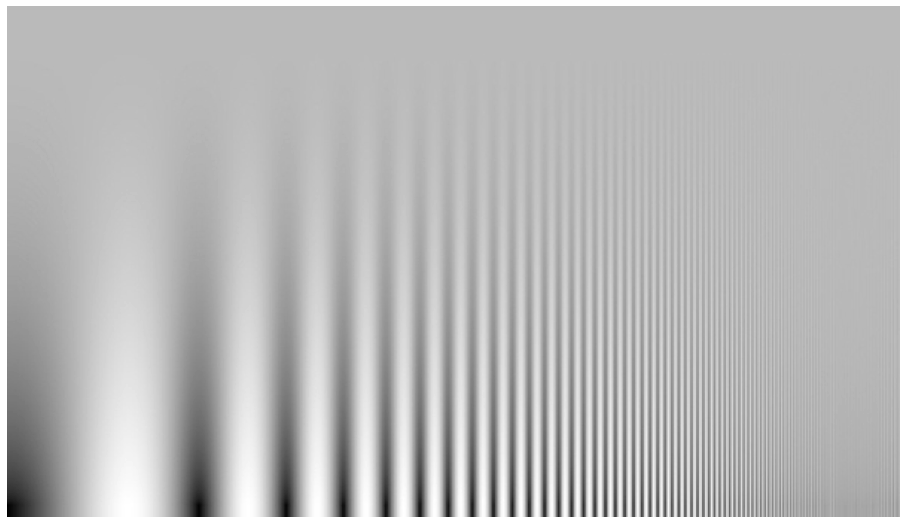

In [2]:
# Read-in CSF image
img_csf = io.imread(im0_url)

plt.figure(figsize=(16, 10))
plt.imshow(img_csf, cmap='gray'), plt.axis("off")
plt.show()

- visual perception + visual neurons tuned to spatial frequency & orientation
- spectral analyses essential to quantify tuning

In the first layers of visual processing (retina, LGN, V1, ...), cells are spatially arranged
in a way that adjacent cells respond to partially overlapping portions of the visual field.

We tend to characterize these cells based on their so-called receptive field properties.
The receptive field of a cell is the region of the visual field that makes a cell change its
firing in the presence of a certain visual stimulation.
The type of visual stimulation that a cell preferrably responds to can differ both in their
spatial as well as temporal properties.
Analogously, we can model the behavior of visual cells using spatial and temporal filters.

We will focus on the spatial properties of visual processing.
Physiological investigations show that neurons in the early visual pathways are tuned to
(1) location, (2) spatial frequency, and (3) orientation.

Spectral analysis helps us to understand and characterize visual inputs particularly with respect
to spatial frequency and orientation, and is therefore essential for understanding vision.

This will be the focus of this notebook.

## The Fourier transform in 2d

1. Going from time to 1d space
2. Fourier transform in 1d-space
3. 2d gratings - It's all about orientation
4. 2d Fourier transform of oriented gratings
5. Decoding frequency and orientation from amplitude spectrum
6. Reducing dimensionality - from 2d back to 1d

### Going from time to 1d space

Let's have a look at our sinusoidal signal again.

In [3]:
def sinusoid(frequency, times, amplitude=1, phase=0, mean=0):
    return amplitude * np.cos(2*np.pi*frequency*times + phase) + mean

In [4]:
T = 4                      # seconds
sampling_rate = 32         # sample per sec
nT = int(sampling_rate*T)  # number of steps
sfrequency = 1             # frequency

t = np.linspace(0, T, nT, endpoint=False)    # Time vector
L = sinusoid(frequency=sfrequency, times=t)  # Luminance signal

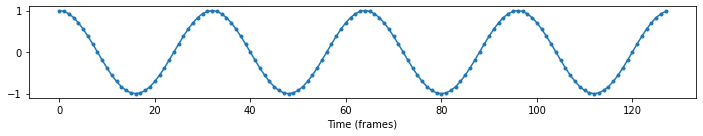

In [5]:
fig, axes = plt.subplots(1,1, sharex="all", figsize=(10, 2))
axes.plot(L, ".-")
axes.set_xlabel("Time (frames)")
fig.tight_layout()
plt.show()

Going from time to space, just requires a re-labeling of units & axes.

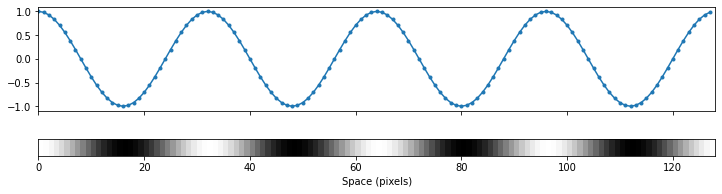

In [6]:
fig, axes = plt.subplots(2,1, sharex="all", figsize=(10, 3))
axes[0].plot(L, ".-")
axes[1].imshow(L * np.ones((1, nT)), cmap="gray", vmin=-1, vmax=1, extent=(0, nT, 0, nT/40))
axes[1].set_xlabel("Space (pixels)"), axes[1].yaxis.set_visible(False)
fig.tight_layout()
plt.show()

Units:
- _frames_ for the temporal dimension
- _pixels_ for the spatial dimension.

These units do not have a physical correspondence yet.

Convention in vision science:
- _seconds_ in temporal domain -> _cycles/s_ (also: _Hz_) for temporal frequencies
- _degrees of visual angle_ in spatial domain -> _cycles/deg_ (also: _cpd_) for spatial frequencies

**These have to be defined by the user!**

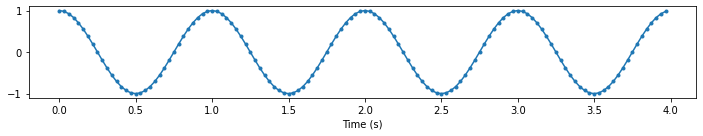

In [7]:
fig, axes = plt.subplots(1,1, sharex="all", figsize=(10, 2))
axes.plot(t, L, ".-")
axes.set_xlabel("Time (s)")
fig.tight_layout()
plt.show()

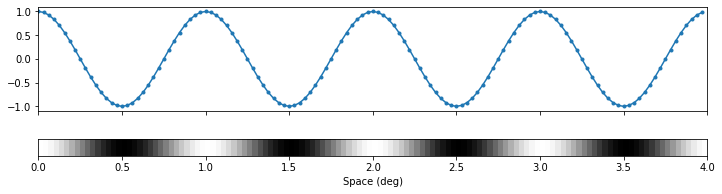

In [8]:
fig, axes = plt.subplots(2,1, sharex="all", figsize=(10, 3))
axes[0].plot(t, L, ".-")
axes[1].imshow(L * np.ones((1, nT)), cmap="gray", vmin=-1, vmax=1, extent=(0, T, 0, T/40))
axes[1].set_xlabel("Space (deg)"), axes[1].yaxis.set_visible(False)
fig.tight_layout()
plt.show()

<center>  Degrees visual angle <a href="https://www.sr-research.com/eye-tracking-blog/background/visual-angle/">ref</a></center> 
<center> <img src="https://www.sr-research.com/wp-content/uploads/2019/11/DegsofVABlog4-768x517.jpg" width="800"/> </center>

**Your monitor resolution + distance from monitor will affect your effective sampling rate in ppd!**

### Fourier transform in 1d-space

- Fourier transform does not care about units
- We can take the same Fourier transform and only change axes

In [9]:
fL = scipy.fft.fftshift(scipy.fft.fftfreq(nT, d=(1/sampling_rate)))  # Get frequency-axis
FL = scipy.fft.fftshift(scipy.fft.fft(L))                            # Perform fft
FL_amp = np.abs(FL) / nT                                             # Calculate amplitude spectrum

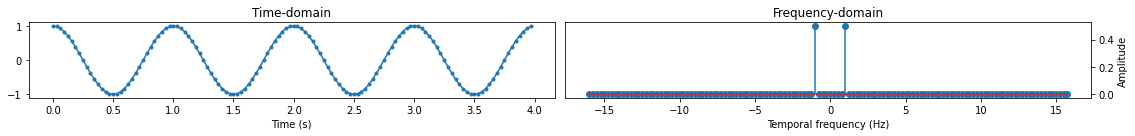

In [10]:
fig, axes = plt.subplots(1, 2, sharex="col", figsize=(16, 2))
axes[0].plot(t, L, ".-")
axes[0].set_title("Time-domain"), axes[0].set_xlabel("Time (s)")

axes[1].stem(fL, FL_amp)
axes[1].yaxis.tick_right(), axes[1].yaxis.set_label_position("right")
axes[1].set_ylabel("Amplitude"), axes[1].set_title("Frequency-domain")
axes[1].set_xlabel("Temporal frequency (Hz)")

fig.tight_layout()
plt.show()

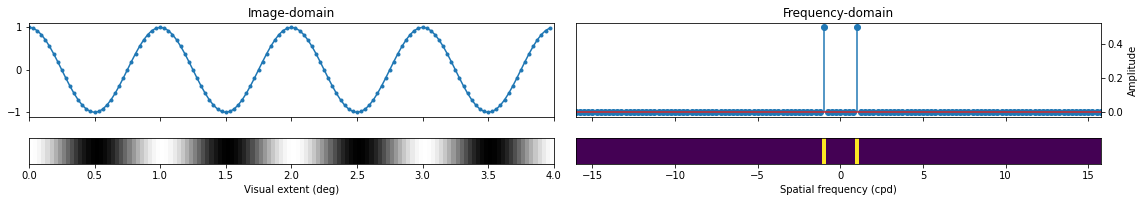

In [11]:
fig, axes = plt.subplots(2, 2, sharex="col", figsize=(16, 3))
axes[0,0].plot(t, L, ".-"), axes[0,0].set_title("Image-domain")

axes[0,1].stem(fL, FL_amp)
axes[0,1].yaxis.tick_right(), axes[0,1].yaxis.set_label_position("right")
axes[0,1].set_ylabel("Amplitude"), axes[0,1].set_title("Frequency-domain")

axes[1,0].imshow(L * np.ones((1, nT)), cmap="gray", vmin=-1, vmax=1, extent=(0, T, 0, T/20))
axes[1,0].yaxis.set_visible(False)
axes[1,0].set_xlabel("Visual extent (deg)")

axes[1,1].imshow(FL_amp * np.ones((1, nT)), extent=(fL.min(), fL.max(), 0, np.max(fL)/10))
axes[1,1].yaxis.set_visible(False)
axes[1,1].set_xlabel("Spatial frequency (cpd)")

fig.tight_layout()
plt.show()

### 2d gratings - It's all about orientation

- Previous parameters: frequency, phase, amplitude and mean
- New: **orientation**

In [12]:
ppd = sampling_rate    # Spatial resolution, pixels per degree
extent = (-T/2, T/2,)  # Visual extent in deg

nX = int(extent[1]*ppd - extent[0]*ppd)
x = np.linspace(extent[0], extent[1], nX, endpoint=False)
yy, xx = np.meshgrid(x, x)

f = scipy.fft.fftshift(scipy.fft.fftfreq(nX, d=(1/ppd)))
fy, fx = np.meshgrid(f, f)
fextent = (f.min(), f.max(),)

In [13]:
def grating(frequency, orientation=0., phase=0, amplitude=1., mean=0.):
    alpha = [np.cos(orientation), np.sin(orientation)]
    return amplitude * np.sin((alpha[0]*xx + alpha[1]*yy) * 2. * np.pi * frequency + phase) + mean

In [14]:
def plot_gratings(frequency, orientation, phase, amplitude, mean):
    g = grating(frequency, orientation*np.pi/180., phase*np.pi/180., amplitude, mean)

    plt.figure(figsize=(10, 6))
    plt.imshow(g, cmap='gray', extent=extent*2, vmin=-1, vmax=1)
    plt.colorbar(), plt.xlabel('Visual angle (deg)'), plt.ylabel('Visual angle (deg)'), plt.title('Grating')

interactive(plot_gratings, frequency=(0.5, 10, 0.5), orientation=(0, 180), phase=(0, 180),
           amplitude=(0, 2, 0.1), mean=(-1, 1, 0.1))

interactive(children=(FloatSlider(value=5.0, description='frequency', max=10.0, min=0.5, step=0.5), IntSlider(…

### 2d Fourier transform of oriented gratings

- Fourier transform is applied to all dimensions independently
- 2d-FT = 1d-FT in each x and y

In [15]:
v1, v2, v3 = 1.2, 2, 2.6

g = grating(frequency=1, orientation=np.pi/2)     # Create 2d grating
g_hcut1 = g[int(v1*ppd), :]                       # Horizontal cut-out 1
g_hcut2 = g[int(v2*ppd), :]                       # Horizontal cut-out 2
g_hcut3 = g[int(v3*ppd), :]                       # Horizontal cut-out 3

gamp_x = np.abs(scipy.fft.fft2(g, axes=1)) / nT   # Compute amplitude in x-direction
gamp_x1 = np.abs(scipy.fft.fft(g_hcut1)) / nT     # Compute amplitude for cut 1
gamp_x2 = np.abs(scipy.fft.fft(g_hcut2)) / nT     # Compute amplitude for cut 2
gamp_x3 = np.abs(scipy.fft.fft(g_hcut3)) / nT     # Compute amplitude for cut 3

In [16]:
# Perform fftshift
gamp_x = scipy.fft.fftshift(gamp_x)
gamp_x1 = scipy.fft.fftshift(gamp_x1)
gamp_x2 = scipy.fft.fftshift(gamp_x2)
gamp_x3 = scipy.fft.fftshift(gamp_x3)

# Get partial amplitude
gamp_x_cuts = np.zeros(shape=gamp_x.shape)
gamp_x_cuts[int(v1*ppd), :] = gamp_x1
gamp_x_cuts[int(v2*ppd), :] = gamp_x2
gamp_x_cuts[int(v3*ppd), :] = gamp_x3

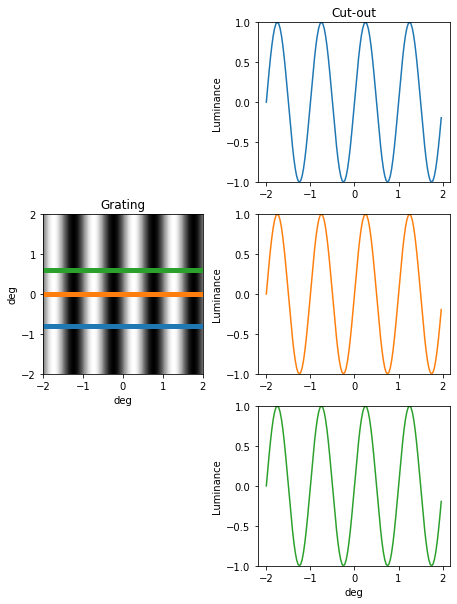

In [17]:
# Plotting
plt.figure(figsize=(20, 10))
plt.subplot(3, 5, 6)
plt.imshow(g, cmap='gray', extent=extent*2), plt.title('Grating'), plt.xlabel('deg'), plt.ylabel('deg')
plt.plot(extent, (v1-T/2, v1-T/2), linewidth=5)
plt.plot(extent, (v2-T/2, v2-T/2), linewidth=5)
plt.plot(extent, (v3-T/2, v3-T/2), linewidth=5)

plt.subplot(3, 5, 2), plt.plot(x, g_hcut1, "C0"), plt.ylim(-1, 1), plt.title('Cut-out'), plt.ylabel('Luminance')
plt.subplot(3, 5, 7), plt.plot(x, g_hcut2, "C1"), plt.ylim(-1, 1), plt.ylabel('Luminance')
plt.subplot(3, 5, 12), plt.plot(x, g_hcut3, "C2"), plt.ylim(-1, 1), plt.xlabel('deg'), plt.ylabel('Luminance')
plt.show()

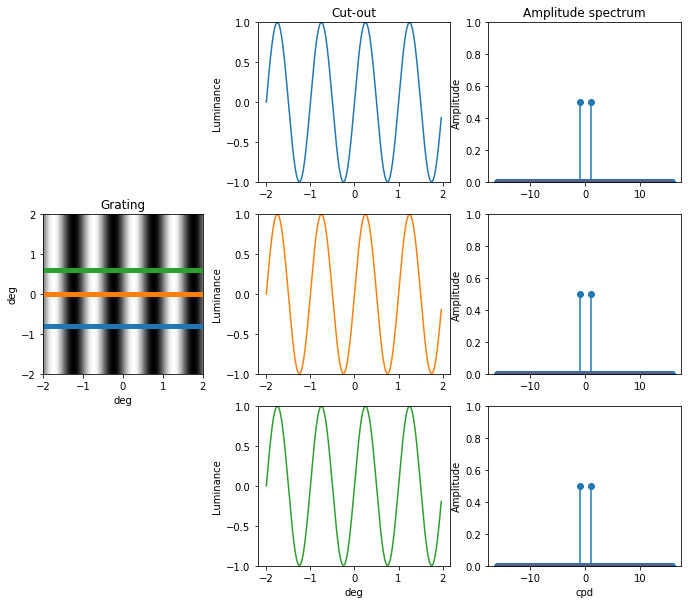

In [18]:
# Plotting
plt.figure(figsize=(20, 10))
plt.subplot(3, 5, 6)
plt.imshow(g, cmap='gray', extent=extent*2), plt.title('Grating'), plt.xlabel('deg'), plt.ylabel('deg')
plt.plot(extent, (v1-T/2, v1-T/2), linewidth=5)
plt.plot(extent, (v2-T/2, v2-T/2), linewidth=5)
plt.plot(extent, (v3-T/2, v3-T/2), linewidth=5)

plt.subplot(3, 5, 2), plt.plot(x, g_hcut1, "C0"), plt.ylim(-1, 1), plt.title('Cut-out'), plt.ylabel('Luminance')
plt.subplot(3, 5, 7), plt.plot(x, g_hcut2, "C1"), plt.ylim(-1, 1), plt.ylabel('Luminance')
plt.subplot(3, 5, 12), plt.plot(x, g_hcut3, "C2"), plt.ylim(-1, 1), plt.xlabel('deg'), plt.ylabel('Luminance')

plt.subplot(3, 5, 3), plt.stem(f, gamp_x1), plt.ylim(0, 1), plt.title('Amplitude spectrum'), plt.ylabel('Amplitude')
plt.subplot(3, 5, 8), plt.stem(f, gamp_x2), plt.ylim(0, 1), plt.ylabel('Amplitude')
plt.subplot(3, 5, 13), plt.stem(f, gamp_x3), plt.ylim(0, 1), plt.xlabel('cpd'), plt.ylabel('Amplitude')
plt.show()

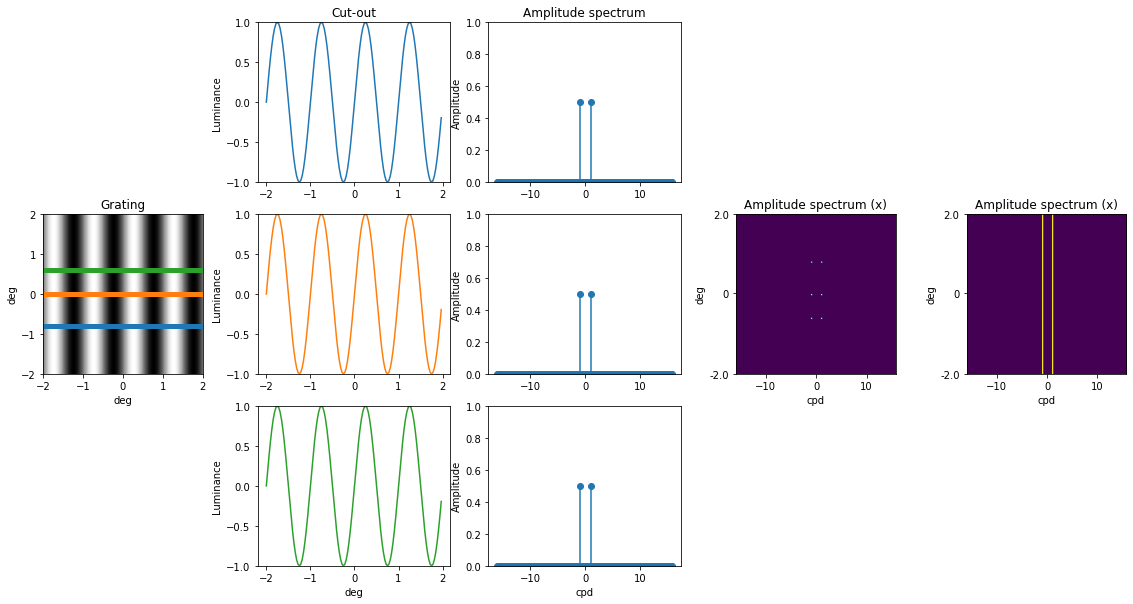

In [19]:
# Plotting
plt.figure(figsize=(20, 10))
plt.subplot(3, 5, 6)
plt.imshow(g, cmap='gray', extent=extent*2), plt.title('Grating'), plt.xlabel('deg'), plt.ylabel('deg')
plt.plot(extent, (v1-T/2, v1-T/2), linewidth=5)
plt.plot(extent, (v2-T/2, v2-T/2), linewidth=5)
plt.plot(extent, (v3-T/2, v3-T/2), linewidth=5)

plt.subplot(3, 5, 2), plt.plot(x, g_hcut1, "C0"), plt.ylim(-1, 1), plt.title('Cut-out'), plt.ylabel('Luminance')
plt.subplot(3, 5, 7), plt.plot(x, g_hcut2, "C1"), plt.ylim(-1, 1), plt.ylabel('Luminance')
plt.subplot(3, 5, 12), plt.plot(x, g_hcut3, "C2"), plt.ylim(-1, 1), plt.xlabel('deg'), plt.ylabel('Luminance')

plt.subplot(3, 5, 3), plt.stem(f, gamp_x1), plt.ylim(0, 1), plt.title('Amplitude spectrum'), plt.ylabel('Amplitude')
plt.subplot(3, 5, 8), plt.stem(f, gamp_x2), plt.ylim(0, 1), plt.ylabel('Amplitude')
plt.subplot(3, 5, 13), plt.stem(f, gamp_x3), plt.ylim(0, 1), plt.xlabel('cpd'), plt.ylabel('Amplitude')

plt.subplot(3, 5, 9)
plt.imshow(gamp_x_cuts, extent=fextent*2), plt.title('Amplitude spectrum (x)'), plt.xlabel('cpd'), plt.ylabel('deg')
plt.yticks([f.min(), 0, f.max()], [-T/2, 0, T/2])

plt.subplot(3, 5, 10)
plt.imshow(gamp_x, extent=fextent*2), plt.title('Amplitude spectrum (x)'), plt.xlabel('cpd'), plt.ylabel('deg')
plt.yticks([f.min(), 0, f.max()], [-T/2, 0, T/2])
plt.show()

Now, let's do the same thing but in y-direction:

In [20]:
g_vcut1 = g[:, int(v1*ppd)]                       # Vertical cut-out 1
g_vcut2 = g[:, int(v2*ppd)]                       # Vertical cut-out 2
g_vcut3 = g[:, int(v3*ppd)]                       # Vertical cut-out 3

gamp_y = np.abs(scipy.fft.fft2(g, axes=0)) / nT   # Compute amplitude in y-direction
gamp_y1 = np.abs(scipy.fft.fft(g_vcut1)) / nT     # Compute amplitude for cut 1
gamp_y2 = np.abs(scipy.fft.fft(g_vcut2)) / nT     # Compute amplitude for cut 2
gamp_y3 = np.abs(scipy.fft.fft(g_vcut3)) / nT     # Compute amplitude for cut 3

In [21]:
# Perform fftshift
gamp_y = scipy.fft.fftshift(gamp_y)
gamp_y1 = scipy.fft.fftshift(gamp_y1)
gamp_y2 = scipy.fft.fftshift(gamp_y2)
gamp_y3 = scipy.fft.fftshift(gamp_y3)

# Get partial amplitude
gamp_y_cuts = np.zeros(shape=gamp_y.shape)
gamp_y_cuts[:, int(v1*ppd)] = gamp_y1
gamp_y_cuts[:, int(v2*ppd)] = gamp_y2
gamp_y_cuts[:, int(v3*ppd)] = gamp_y3

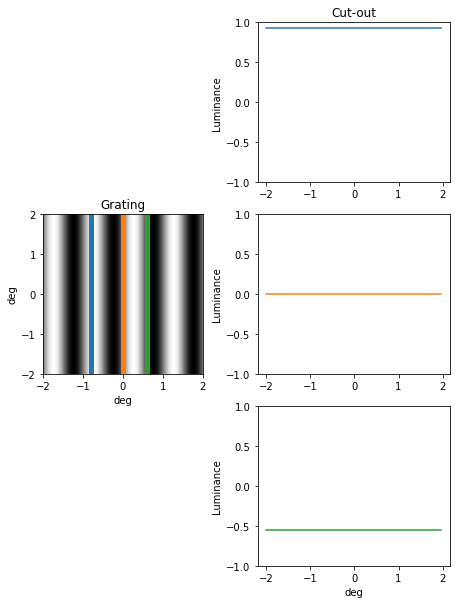

In [22]:
# Plotting
plt.figure(figsize=(20, 10))
plt.subplot(3, 5, 6)
plt.imshow(g, cmap='gray', extent=extent*2), plt.title('Grating'), plt.xlabel('deg'), plt.ylabel('deg')
plt.plot((v1-T/2, v1-T/2), extent, linewidth=5)
plt.plot((v2-T/2, v2-T/2), extent, linewidth=5)
plt.plot((v3-T/2, v3-T/2), extent, linewidth=5)

plt.subplot(3, 5, 2), plt.plot(x, g_vcut1, "C0"), plt.ylim(-1, 1), plt.title('Cut-out'), plt.ylabel('Luminance')
plt.subplot(3, 5, 7), plt.plot(x, g_vcut2, "C1"), plt.ylim(-1, 1), plt.ylabel('Luminance')
plt.subplot(3, 5, 12), plt.plot(x, g_vcut3, "C2"), plt.ylim(-1, 1), plt.xlabel('deg'), plt.ylabel('Luminance')
plt.show()

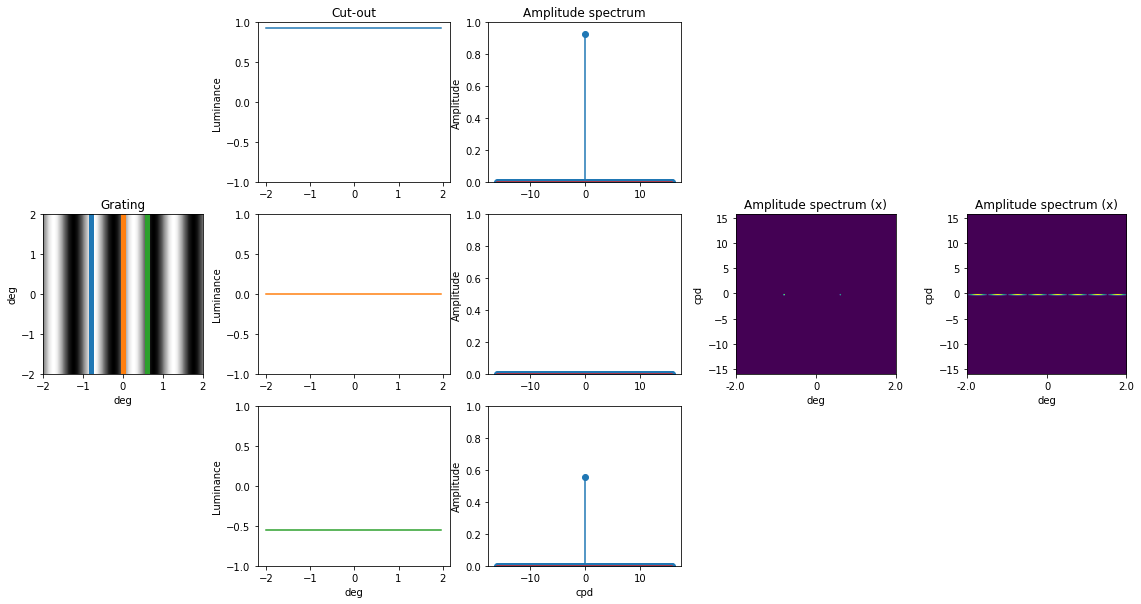

In [23]:
# Plotting
plt.figure(figsize=(20, 10))
plt.subplot(3, 5, 6)
plt.imshow(g, cmap='gray', extent=extent*2), plt.title('Grating'), plt.xlabel('deg'), plt.ylabel('deg')
plt.plot((v1-T/2, v1-T/2), extent, linewidth=5)
plt.plot((v2-T/2, v2-T/2), extent, linewidth=5)
plt.plot((v3-T/2, v3-T/2), extent, linewidth=5)

plt.subplot(3, 5, 2), plt.plot(x, g_vcut1, "C0"), plt.ylim(-1, 1), plt.title('Cut-out'), plt.ylabel('Luminance')
plt.subplot(3, 5, 7), plt.plot(x, g_vcut2, "C1"), plt.ylim(-1, 1), plt.ylabel('Luminance')
plt.subplot(3, 5, 12), plt.plot(x, g_vcut3, "C2"), plt.ylim(-1, 1), plt.xlabel('deg'), plt.ylabel('Luminance')

plt.subplot(3, 5, 3), plt.stem(f, gamp_y1), plt.ylim(0, 1), plt.title('Amplitude spectrum'), plt.ylabel('Amplitude')
plt.subplot(3, 5, 8), plt.stem(f, gamp_y2), plt.ylim(0, 1), plt.ylabel('Amplitude')
plt.subplot(3, 5, 13), plt.stem(f, gamp_y3), plt.ylim(0, 1), plt.xlabel('cpd'), plt.ylabel('Amplitude')

plt.subplot(3, 5, 9)
plt.imshow(gamp_y_cuts, extent=fextent*2), plt.title('Amplitude spectrum (x)'), plt.xlabel('deg'), plt.ylabel('cpd')
plt.xticks([f.min(), 0, f.max()], [-T/2, 0, T/2])

plt.subplot(3, 5, 10)
plt.imshow(gamp_y, extent=fextent*2), plt.title('Amplitude spectrum (x)'), plt.xlabel('deg'), plt.ylabel('cpd')
plt.xticks([f.min(), 0, f.max()], [-T/2, 0, T/2])
plt.show()

Now, we have the 1d-fft of our 2d-grating both in the x-direction and in the y-direction:

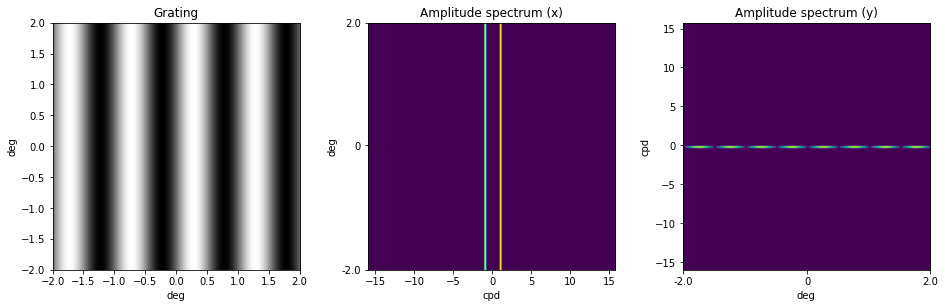

In [24]:
# Plotting
plt.figure(figsize=(16, 10))
plt.subplot(2, 3, 1)
plt.imshow(g, cmap='gray', extent=extent*2), plt.title('Grating'), plt.xlabel('deg'), plt.ylabel('deg')

plt.subplot(2, 3, 2)
plt.imshow(gamp_x, extent=fextent*2), plt.title('Amplitude spectrum (x)'), plt.xlabel('cpd'), plt.ylabel('deg')
plt.yticks([f.min(), 0, f.max()], [-T/2, 0, T/2])

plt.subplot(2, 3, 3)
plt.imshow(gamp_y, extent=fextent*2), plt.title('Amplitude spectrum (y)'), plt.xlabel('deg'), plt.ylabel('cpd')
plt.xticks([f.min(), 0, f.max()], [-T/2, 0, T/2])
plt.show()

To perform the full 2d-fft, we simply perform another 1d-fft in the
direction that we have omitted.

In [25]:
Fg_x = scipy.fft.fft2(g, axes=1)      # fft in x-direction
Fg_xy = scipy.fft.fft2(Fg_x, axes=0)  # fft in y-direction
gamp_xy = np.abs(Fg_xy) / np.size(g)

Fg_y = scipy.fft.fft2(g, axes=0)      # fft in y-direction
Fg_yx = scipy.fft.fft2(Fg_y, axes=1)  # fft in x-direction
gamp_yx = np.abs(Fg_yx) / np.size(g)

In [26]:
# Perform fftshift
gamp_xy = scipy.fft.fftshift(gamp_xy)
gamp_yx = scipy.fft.fftshift(gamp_yx)

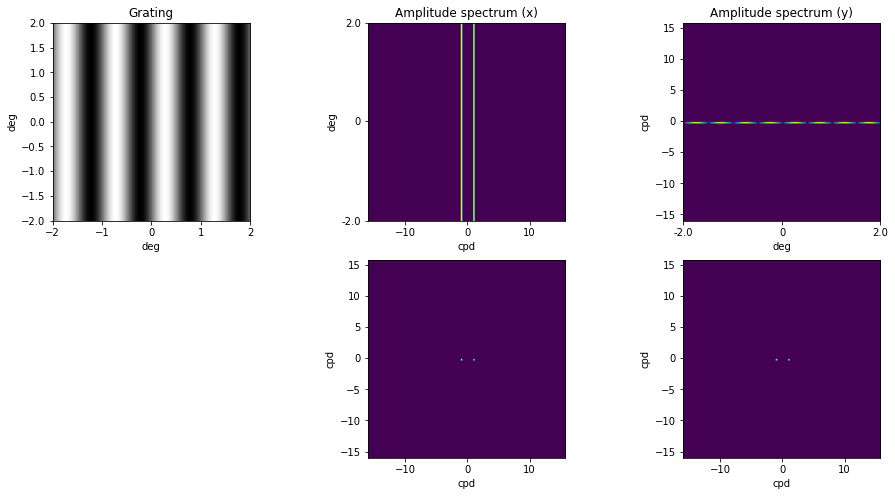

In [27]:
# Plotting
plt.figure(figsize=(16, 8))
plt.subplot(2, 3, 1)
plt.imshow(g, cmap='gray', extent=extent*2), plt.title('Grating'), plt.xlabel('deg'), plt.ylabel('deg')

plt.subplot(2, 3, 2)
plt.imshow(gamp_x, extent=fextent*2), plt.title('Amplitude spectrum (x)'), plt.xlabel('cpd'), plt.ylabel('deg')
plt.yticks([f.min(), 0, f.max()], [-T/2, 0, T/2])

plt.subplot(2, 3, 3)
plt.imshow(gamp_y, extent=fextent*2), plt.title('Amplitude spectrum (y)'), plt.xlabel('deg'), plt.ylabel('cpd')
plt.xticks([f.min(), 0, f.max()], [-T/2, 0, T/2])

plt.subplot(2, 3, 5)
plt.imshow(gamp_xy, extent=fextent*2), plt.xlabel('cpd'), plt.ylabel('cpd')

plt.subplot(2, 3, 6)
plt.imshow(gamp_yx, extent=fextent*2), plt.xlabel('cpd'), plt.ylabel('cpd')
plt.show()

But what happens to the 2d-amplitude spectrum if we change the parameters of our grating?

In [28]:
def plot_grating_amp(frequency, orientation, phase, amplitude, mean):
    g = grating(frequency, orientation*np.pi/180., phase*np.pi/180., amplitude, mean)
    g_amp = np.abs(scipy.fft.fftshift(scipy.fft.fft2(g))) / np.size(g)

    plt.figure(figsize=(14, 6))
    plt.subplot(121)
    plt.imshow(g, cmap='gray', extent=extent*2, vmin=-1, vmax=1), plt.colorbar()
    plt.xlabel('Visual angle (deg)'), plt.ylabel('Visual angle (deg)'), plt.title('Grating')
    
    plt.subplot(122)
    plt.imshow(g_amp, extent=fextent*2, vmin=0, vmax=0.5), plt.colorbar()
    plt.xlabel('Spatial frequency (cpd)'), plt.ylabel('Spatial frequency (cpd)'), plt.title('Amplitude spectrum')

interactive(plot_grating_amp, frequency=(0.5, 10, 0.5), orientation=(0, 180), phase=(0, 180),
           amplitude=(0, 2, 0.1), mean=(-1, 1, 0.1))

interactive(children=(FloatSlider(value=5.0, description='frequency', max=10.0, min=0.5, step=0.5), IntSlider(…

### Decoding frequency and orientation from amplitude spectrum

- spatial frequency can be decoded from the _distance_ to the origin.
- orientation can be decoded from the _angle_ to the origin.

In [29]:
def plot_grating_amp(frequency, orientation, phase, amplitude, mean):
    g = grating(frequency, orientation*np.pi/180., phase*np.pi/180., amplitude, mean)
    g_amp = np.abs(scipy.fft.fftshift(scipy.fft.fft2(g))) / np.size(g)
    
    g_amp2 = np.copy(g_amp)
    g_amp2[int(nX/2), int(nX/2)] = 0                   # Ignore DC-component
    fy_peak = np.abs(fy.flatten()[np.argmax(g_amp2)])  # Find peak frequency in y-direction
    fx_peak = np.abs(fx.flatten()[np.argmax(g_amp2)])  # Find peak frequency in x-direction
    magnitude = np.sqrt(fy_peak**2 + fx_peak**2)
    direction = np.arctan2(fy_peak, fx_peak) * 180/np.pi

    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.imshow(g, cmap='gray', extent=extent*2, vmin=-1, vmax=1), plt.colorbar()
    plt.xlabel('Visual angle (deg)'), plt.ylabel('Visual angle (deg)'), plt.title('Grating')
    
    plt.subplot(122)
    plt.imshow(g_amp, extent=fextent*2, vmin=0, vmax=0.5), plt.colorbar()
    plt.xlabel('Spatial frequency (cpd)'), plt.ylabel('Spatial frequency (cpd)'), plt.title('Amplitude spectrum')
    
    print("Distance = Frequency:", magnitude)
    print("Angle = Orientation:", direction)

interactive(plot_grating_amp, frequency=(0.5, 10, 0.5), orientation=(-90, 90), phase=(0, 180),
           amplitude=(0, 2, 0.1), mean=(-1, 1, 0.1))

interactive(children=(FloatSlider(value=5.0, description='frequency', max=10.0, min=0.5, step=0.5), IntSlider(…

### Reducing dimensionality - from 2d back to 1d

There are cases in which it would be useful to reduce the dimensionality of the 2d frequency spectra:
- for visualization purposes
- if input singals are circular symmetric (e.g. Gabors)
- if we want to know the overall ampltiude in individual frequency bands (i.e. averaged over orientation)

Common methods to reduce dimensionality:
1. Using cut-throughs
2. Using radial-averaging

#### Using cut-throughs

The easiest way to reduce the dimensionality is by using cut-throughs (here: vertical and horizontal).
This is particularly useful if you know the orientation of your signal in advance.
However, for orientations other than vertical and horizontal, getting the right cut-through is not very convenient, since we have to rotate our cut-through with the orientation of the grating.

In [30]:
def plot_cuts(frequency, orientation):
    g = grating(frequency, orientation*np.pi/180.)
    gamp = np.abs(scipy.fft.fftshift(scipy.fft.fft2(g))) / np.size(g)
    gamp1d_x = gamp[int(nX/2), :]
    gamp1d_y = gamp[:, int(nX/2)]

    plt.figure(figsize=(16, 4))
    plt.subplot(131, aspect=1.), plt.imshow(g, cmap='gray', extent=extent*2)
    plt.ylabel('Visual angle (deg)'), plt.xlabel('Visual angle (deg)')

    plt.subplot(132)
    plt.imshow(gamp, extent=[f.min(), f.max(),]*2, vmin=0, vmax=0.5)
    plt.plot(fextent, (0, 0), 'r'), plt.plot((0, 0), fextent, 'b')
    plt.ylabel('SF (cpd)'), plt.xlabel('SF (cpd)'), plt.title('Amplitude spectrum'), plt.colorbar()

    plt.subplot(133)
    plt.stem(f, gamp1d_x, linefmt='r', markerfmt='ro'), plt.stem(f, gamp1d_y, linefmt='b', markerfmt='bo')
    plt.title('Cut through'), plt.ylabel('Amplitude'), plt.xlabel('SF (cpd)'), plt.ylim(0, 0.6)
    plt.show()

interactive(plot_cuts, frequency=(0.5, 10, 0.5), orientation=(0,180))

interactive(children=(FloatSlider(value=5.0, description='frequency', max=10.0, min=0.5, step=0.5), IntSlider(…

#### Using radial-averaging / radial-summing

If you are interested in how much power is in the different spatial frequency
bands disregarding the orientation of the signal, one common way to reduce
dimensionality is called-radial averaging.

To perform radial averaging, you calculate the mean (or sum) amplitude
along equidistant circles from the origin.

Let's see how this would look like:

In [31]:
def radial_average(amp, fx, fy, rounding_factor=0.5, only_full_circles=True):
    # create bins by rounding to int
    radii = np.sqrt(fx**2 + fy**2)
    radii = (radii / rounding_factor).astype(int)

    # creates bins from 0 to radii.max()
    sum_bins = np.bincount(radii.ravel(), amp.ravel())

    # count how often a radius is represented
    count_bins = np.bincount(radii.ravel())

    # mean of each radius bin
    means = np.ma.divide(sum_bins, count_bins)

    # radius each bin represents
    bins = np.arange(0, means.shape[0]) * rounding_factor
    
    # remove masked values
    bins = bins[~means.mask]
    means = means[~means.mask]

    if only_full_circles:
        max_bin = radii[int(radii.shape[0]/2), :].max()
        means = means[:max_bin]
        bins = bins[:max_bin]
    return means, bins

In [32]:
def plot_radial(frequency, orientation, helper_lines=False):
    g = grating(frequency, orientation*np.pi/180.)
    gamp = np.abs(scipy.fft.fftshift(scipy.fft.fft2(g))) / np.size(g)
    gamp_mean, f_mean = radial_average(gamp, fx, fy)

    plt.figure(figsize=(16, 4))
    plt.subplot(131)
    plt.imshow(g, cmap='gray', extent=extent*2), plt.title('Grating'), plt.xlabel('Visual angle (deg)')

    plt.subplot(132), plt.imshow(gamp, extent=fextent*2)
    plt.xlabel('SF (cpd)'), plt.title('Amplitude spectrum')
    if helper_lines:
        plt.plot(fextent, (0, 0), 'w--', linewidth=0.5), plt.plot((0, 0), fextent, 'w--', linewidth=0.5)
        if frequency is not None:
            f2d = np.round(np.sqrt(fy**2 + fx**2))
            circle = np.round(frequency) == f2d
            plt.plot(fx[circle], fy[circle], 'w.', markersize=0.5)

    plt.subplot(133), plt.stem(f_mean, gamp_mean), plt.ylim(0, 0.01)
    plt.title('Radial average'), plt.ylabel('Amplitude'), plt.xlabel('SF (cpd)')
    plt.show()

interactive(plot_radial, frequency=(0.5, 10, 0.5), orientation=(0,180), helper_lines=False)

interactive(children=(FloatSlider(value=5.0, description='frequency', max=10.0, min=0.5, step=0.5), IntSlider(…

## Applications

1. Understanding signals
2. Modifying signals in frequency space
3. Visual filters

### Applications: Understanding signals

1. **Plaids**
2. Gaussians
3. Oriented Gaussians
4. **Gabors**
5. Square-wave gratings
6. **Natural images**

#### Plaids
- visual system selective for spatial frequency and orientation
- adaptation experiments

In [33]:
def plot_plaids(frequency1, orientation1, frequency2, orientation2):
    g1 = grating(frequency1, orientation1*np.pi/180.)
    g2 = grating(frequency2, orientation2*np.pi/180.)
    plaid = g1 + g2
    g1_amp = np.abs(scipy.fft.fftshift(scipy.fft.fft2(g1))) / np.size(g1)
    g2_amp = np.abs(scipy.fft.fftshift(scipy.fft.fft2(g2))) / np.size(g1)
    plaid_amp = np.abs(scipy.fft.fftshift(scipy.fft.fft2(plaid))) / np.size(g1)
    
    plt.figure(figsize=(18, 8))
    plt.subplot(231), plt.imshow(g1, cmap='gray', extent=extent*2, vmin=-2, vmax=2), plt.title('Grating 1'), plt.colorbar()
    plt.subplot(232), plt.imshow(g2, cmap='gray', extent=extent*2, vmin=-2, vmax=2), plt.title('Grating 2'), plt.colorbar()
    plt.subplot(233), plt.imshow(plaid, cmap='gray', extent=extent*2, vmin=-2, vmax=2), plt.title('Plaid'), plt.colorbar()

    plt.subplot(234), plt.imshow(g1_amp, extent=fextent*2, vmin=0, vmax=0.5), plt.title('Amplitude'), plt.colorbar()
    plt.subplot(235), plt.imshow(g2_amp, extent=fextent*2, vmin=0, vmax=0.5), plt.title('Amplitude'), plt.colorbar()
    plt.subplot(236), plt.imshow(plaid_amp, extent=fextent*2, vmin=0, vmax=0.5), plt.title('Amplitude'), plt.colorbar()

interactive(plot_plaids, frequency1=(0, 5, 0.5), orientation1=(0,180),
            frequency2=(0, 5, 0.5), orientation2=(0,180))

interactive(children=(FloatSlider(value=2.0, description='frequency1', max=5.0, step=0.5), IntSlider(value=90,…

#### Gaussians
As always, Gaussians play an important role in spectral analysis because they come with
a useful property:

Gaussians in the image-domain will be Gaussians in the frequency-domain.

In [34]:
def gaussian2d(x, y, sigma, orientation=0):
    a = (np.cos(orientation)**2 / (2*sigma[0]**2)) + (np.sin(orientation)**2 / (2*sigma[1]**2))
    b = -(np.sin(2*orientation) / (4*sigma[0]**2)) + (np.sin(2*orientation) / (4*sigma[1]**2))
    c = (np.sin(orientation)**2 / (2*sigma[0]**2)) + (np.cos(orientation)**2 / (2*sigma[1]**2))
    return np.exp(-(a*x**2 + 2*b*x*y + c*y**2))

In [35]:
def plot_gauss(sigma):
    gauss = gaussian2d(xx, yy, sigma=[sigma, sigma])
    gauss_amp = np.abs(scipy.fft.fftshift(scipy.fft.fft2(gauss))) / np.size(gauss)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(121), plt.imshow(gauss, cmap='gray', extent=extent*2), plt.title('Image')
    plt.subplot(122), plt.imshow(gauss_amp, extent=fextent*2), plt.title('Amplitude')

interactive(plot_gauss, sigma=(0.01, 0.2, 0.01))

interactive(children=(FloatSlider(value=0.09999999999999999, description='sigma', max=0.2, min=0.01, step=0.01…

#### Oriented Gaussians

In [36]:
def plot_ori_gauss(sigmax, sigmay, orientation):
    gauss = gaussian2d(xx, yy, sigma=[sigmax, sigmay], orientation=orientation*np.pi/180.)
    gauss_amp = np.abs(scipy.fft.fftshift(scipy.fft.fft2(gauss))) / np.size(gauss)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(121), plt.imshow(gauss, cmap='gray', extent=extent*2), plt.title('Image')
    plt.subplot(122), plt.imshow(gauss_amp, extent=fextent*2), plt.title('Amplitude')

interactive(plot_ori_gauss, sigmax=(0.01, 0.2, 0.01), sigmay=(0.01, 0.2, 0.01), orientation=(0,180))

interactive(children=(FloatSlider(value=0.09999999999999999, description='sigmax', max=0.2, min=0.01, step=0.0…

#### Gabors

- like plaids: defined by spatial frequency & orientation
- in addition: localized in space

In [37]:
def plot_gabor(frequency, orientation, sigma):
    g1 = grating(frequency, orientation=orientation*np.pi/180.)
    gauss = gaussian2d(xx, yy, sigma=[sigma, sigma])
    gabor = g1 * gauss
    
    g1_amp = np.abs(scipy.fft.fftshift(scipy.fft.fft2(g1))) / np.size(gabor)
    gauss_amp = np.abs(scipy.fft.fftshift(scipy.fft.fft2(gauss))) / np.size(gabor)
    gabor_amp = np.abs(scipy.fft.fftshift(scipy.fft.fft2(gabor))) / np.size(gabor)
    
    plt.figure(figsize=(18, 8))
    plt.subplot(231), plt.imshow(g1, cmap='gray', extent=extent*2, vmin=-1, vmax=1), plt.title('Grating'), plt.colorbar()
    plt.subplot(232), plt.imshow(gauss, cmap='gray', extent=extent*2, vmin=-1, vmax=1), plt.title('Gaussian'), plt.colorbar()
    plt.subplot(233), plt.imshow(gabor, cmap='gray', extent=extent*2, vmin=-1, vmax=1), plt.title('Gabor'), plt.colorbar()

    plt.subplot(234), plt.imshow(g1_amp, extent=fextent*2), plt.title('Amplitude'), plt.colorbar()
    plt.subplot(235), plt.imshow(gauss_amp, extent=fextent*2), plt.title('Amplitude'), plt.colorbar()
    plt.subplot(236), plt.imshow(gabor_amp, extent=fextent*2), plt.title('Amplitude'), plt.colorbar()

interactive(plot_gabor, frequency=(1, 10), orientation=(0,180), sigma=(0.2, 1, 0.1))

interactive(children=(IntSlider(value=5, description='frequency', max=10, min=1), IntSlider(value=90, descript…

#### Square-wave grating

Square-wave gratings posess power in a broad band of spatial frequencies.
The peaks in amplitude spectrum are at the so-called odd-harmonics, i.e. odd multiples of the fundamental frequency of the grating.

In [38]:
def plot_edges(frequency, orientation):
    edge = grating(frequency, orientation=orientation*np.pi/180.)
    edge[edge<=0] = -1
    edge[edge>0] = 1
    edge_amp = np.abs(scipy.fft.fftshift(scipy.fft.fft2(edge))) / np.size(edge)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(121), plt.imshow(edge, cmap='gray', extent=extent*2), plt.title('Image')
    plt.subplot(122), plt.imshow(edge_amp, extent=fextent*2, vmax=0.25), plt.title('Amplitude')

interactive(plot_edges, frequency=(0., 3, 0.5), orientation=(0,180))

interactive(children=(FloatSlider(value=1.5, description='frequency', max=3.0, step=0.5), IntSlider(value=90, …

#### Natural images

Natural images have a very specific frequency spectrum.

Let's look at one example from the UPenn natural image database.

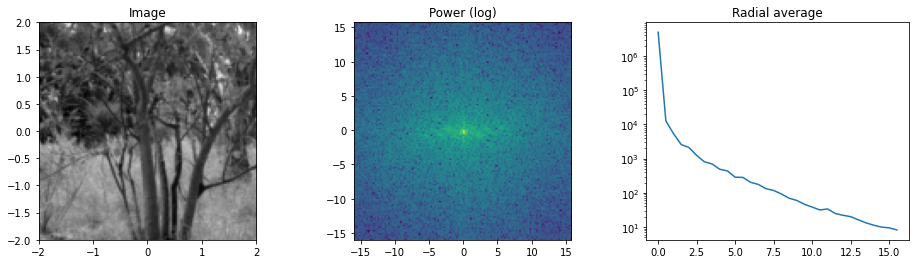

In [39]:
# Import natural image, crop to squared shape and resize
img = io.imread(im1_url).mean(2)
img = img[0:np.minimum(img.shape[0], img.shape[1]), 0:np.minimum(img.shape[0], img.shape[1])]
img = resize(img, [nX, nX]) / 255
img_power = np.abs(scipy.fft.fftshift(scipy.fft.fft2(img))) ** 2
impower_mean, fm = radial_average(img_power, fx, fy)
    
plt.figure(figsize=(16, 4))
plt.subplot(131), plt.imshow(img, cmap='gray', extent=extent*2), plt.title('Image')
plt.subplot(132), plt.imshow(np.log(img_power+0.0001), extent=fextent*2), plt.title('Power (log)')
plt.subplot(133), plt.plot(fm, impower_mean), plt.yscale('log'), plt.title('Radial average')
plt.show()

- Spectral power decreases proportionally with increasing spatial frequency in a `1/frequency` fashion
- Remember: user defines size in deg!

### Applications: Modifying signals in frequency-space

So far, we have characterized images in the frequency-domain

However, sometimes it is useful to work with signals in frequency space and go back via ifft.

Examples:
1. Create a sine-wave grating
2. Create 1/f noise (natural image noise)
3. **Phase shuffling**
4. Relationship between contrast and spectral power*
5. Summation of signals
6. Multiplication (=filtering)

For a list of correspondences between the time / space domain and the frequency domain,
check e.g. https://measurebiology.org/wiki/Assignment_8,_Part_0:_convolution_practice

As basis for our demonstrations, lets use two Gabor patches and two natural images:

In [40]:
# Example 1: Create two Gabors in the image domain
g1 = grating(10., orientation=np.pi/4) * gaussian2d(xx, yy, sigma=[0.5, 0.5], orientation=np.pi/4)
g2 = grating(2., orientation=np.pi/7) * gaussian2d(xx, yy, sigma=[0.5, 0.5], orientation=np.pi/4)

# Perform fft
g1_fft = scipy.fft.fft2(g1)
g2_fft = scipy.fft.fft2(g2)

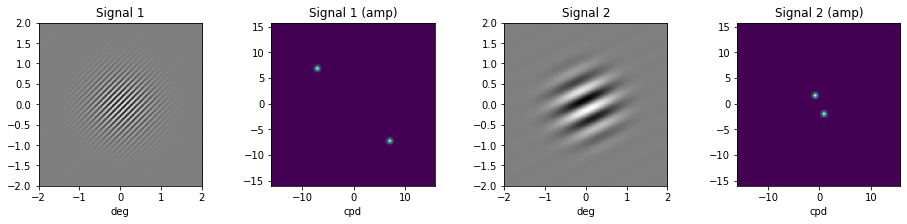

In [41]:
# Plotting
plt.figure(figsize=(16, 3))
plt.subplot(141)
plt.imshow(g1, cmap='gray', extent=extent*2), plt.title('Signal 1'), plt.xlabel('deg')
plt.subplot(142), plt.imshow(np.abs(scipy.fft.fftshift(g1_fft)), extent=fextent*2)
plt.title('Signal 1 (amp)'), plt.xlabel('cpd')

plt.subplot(143)
plt.imshow(g2, cmap='gray', extent=extent*2), plt.title('Signal 2'), plt.xlabel('deg')
plt.subplot(144), plt.imshow(np.abs(scipy.fft.fftshift(g2_fft)), extent=fextent*2)
plt.title('Signal 2 (amp)'), plt.xlabel('cpd')
plt.show()

In [42]:
# Example 2: Read two images
im1 = io.imread(im3_url).mean(2)
im2 = io.imread(im2_url).mean(2)

# For convenience, we resize the images to the same shape/size as the grating
im1 = resize(im1, [nX, nX]) / 255
im2 = resize(im2, [nX, nX]) / 255

# Perform fft and visualize amplitude spectra
im1_fft = scipy.fft.fft2(im1)
im2_fft = scipy.fft.fft2(im2)

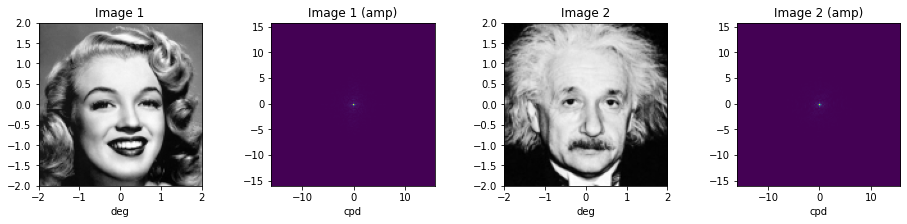

In [43]:
# Plotting
plt.figure(figsize=(16, 3))
plt.subplot(141)
plt.imshow(im1, cmap='gray', extent=extent*2), plt.title('Image 1'), plt.xlabel('deg')
plt.subplot(142), plt.imshow(np.abs(scipy.fft.fftshift(im1_fft)), extent=fextent*2)
plt.title('Image 1 (amp)'), plt.xlabel('cpd')

plt.subplot(143)
plt.imshow(im2, cmap='gray', extent=extent*2), plt.title('Image 2'), plt.xlabel('deg')
plt.subplot(144), plt.imshow(np.abs(scipy.fft.fftshift(im2_fft)), extent=fextent*2)
plt.title('Image 2 (amp)'), plt.xlabel('cpd')
plt.show()

#### Create a sine-wave grating

In [44]:
# Define an amplitude spectrum which is 0 everywhere except at fy=0, fx=1
sin_freq = 1.
sin_amp = np.zeros([nX, nX], dtype=complex)
sin_amp[np.abs(fx) == sin_freq] = (nX*nX)*1j
sin_amp[fx == -sin_freq] = (-nX*nX)*1j
sin_amp[fy != 0] = 0

# Perform ifft
sin_ifft = np.real(scipy.fft.ifft2(scipy.fft.ifftshift(sin_amp)))

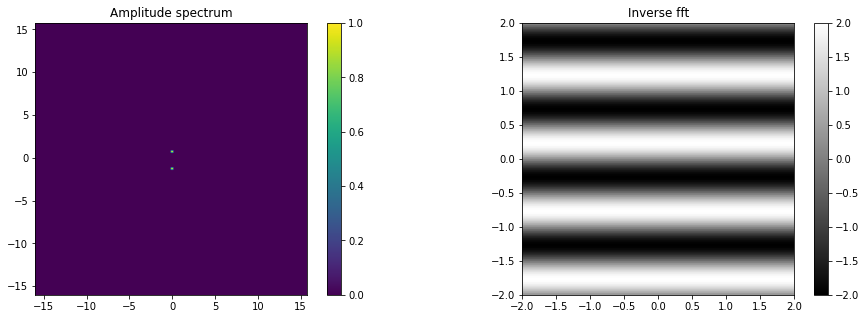

In [45]:
plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.imshow(np.abs(sin_amp) / np.size(sin_amp), extent=fextent*2), plt.colorbar(), plt.title("Amplitude spectrum")

plt.subplot(122)
plt.imshow(sin_ifft, extent=extent*2, cmap='gray'), plt.colorbar(), plt.title("Inverse fft")
plt.show()

#### Create 1/f noise

As we have discovered previously, natural images tend to have a power spectrum with
a 1/f distribution.
For some phenomena, it might be useful to have a stimulus which has the same
amplitude spectra as natural images, but with very different phase spectra.
These noise stimuli are often referred to as "1/f noise" or "pink noise".

1/f noise is a good example for a stimulus which can be much easier defined in the frequency domain.

In [46]:
# Create random (=white) noise
white_fft = np.random.rand(nX, nX) - 0.5 + (np.random.rand(nX, nX) - 0.5)*1j

# Calculate 2d-frequency-array
f2d = np.sqrt(fx**2 + fy**2)
f2d[f2d == 0 ] = 1 # needed to avoid division by 0

# Generate 1/f noise
noise1f_fft = white_fft / f2d * nX**2
noise1f_fft[f2d == 0] = 0

# Perform ifft
noise1f_ifft = np.real(scipy.fft.ifft2(scipy.fft.ifftshift(noise1f_fft)))

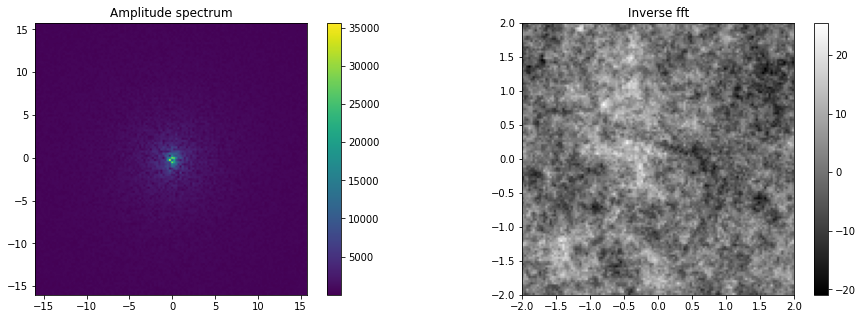

In [47]:
plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.imshow(np.abs(noise1f_fft), extent=fextent*2), plt.colorbar(), plt.title("Amplitude spectrum")

plt.subplot(122)
plt.imshow(noise1f_ifft, extent=extent*2, cmap='gray'), plt.colorbar(), plt.title("Inverse fft")
plt.show()

#### Phase shuffling

- Often: focus on amplitude spectra of our visual stimuli
- However: relevance of the phase information for visual processing -> Phase shuffling

In [48]:
noise_matrix = np.random.rand(nX, nX) * 2 * np.pi * 1j   # Generate noise matrix
im2_random_fft = np.abs(im2_fft) * np.exp(noise_matrix)  # Randomize phase
im2_random = np.real(scipy.fft.ifft2(im2_random_fft))    # Perform ifft2

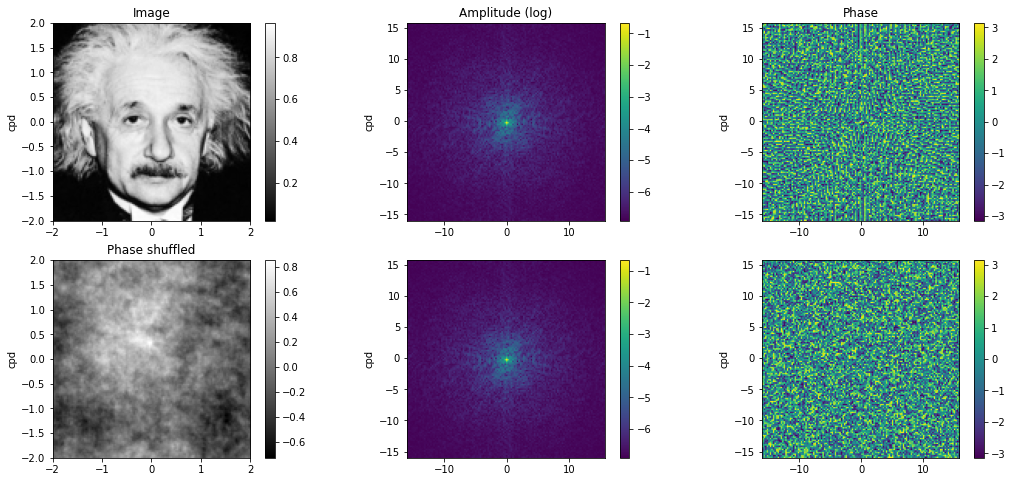

In [49]:
amp1 = np.log(scipy.fft.fftshift(np.abs(im2_fft)) / np.size(im2) + 0.001)
phase1 = scipy.fft.fftshift(np.angle(im2_fft))
amp2 = np.log(scipy.fft.fftshift(np.abs(im2_random_fft)) / np.size(im2) + 0.001)
phase2 = scipy.fft.fftshift(np.angle(im2_random_fft))

# Plotting
plt.figure(figsize=(18, 8))
plt.subplot(231), plt.imshow(im2, cmap='gray', extent=extent*2), plt.colorbar(), plt.title('Image'), plt.ylabel('cpd')
plt.subplot(232), plt.imshow(amp1, extent=fextent*2), plt.colorbar(), plt.title('Amplitude (log)'), plt.ylabel('cpd')
plt.subplot(233), plt.imshow(phase1, extent=fextent*2), plt.colorbar(), plt.title('Phase'), plt.ylabel('cpd')

plt.subplot(234), plt.imshow(im2_random, cmap='gray', extent=extent*2), plt.colorbar(), plt.title('Phase shuffled'), plt.ylabel('cpd')
plt.subplot(235), plt.imshow(amp2, extent=fextent*2), plt.colorbar(), plt.ylabel('cpd')
plt.subplot(236), plt.imshow(phase2, extent=fextent*2), plt.colorbar(), plt.ylabel('cpd')
plt.show()

#### RMS contrast in image and frequency space

There is a direct correspondence between the RMS contrast (root-mean-squared contrast) of an image
and the spectral power of the image.
For a constant mean intensity (for simplicity, we use 0 here), we can calculate the spectral power
of an image by computing it's contrast energy which is `rms**2 / area`.

It is important to be aware of this relationship.
If you use stimuli with different rms-contrasts, this automatically means that the image
with the lower contrast will have less spectral power (ie energy).
Just by definition, this means that the lower contrast / lower power stimulus will generate
less response in the early visual system.
This is a typically confound in vision studies.
Be aware to always control for this when defining your stimuli.

In [50]:
# Compute rms contrast, contrast energy and power for image 1:
sig1 = im1
sig1 = sig1 - sig1.mean()
sig1_fft = scipy.fft.fft2(sig1)
sig1_power = np.abs(sig1_fft)**2.

sig1_rms = sig1.std()
sig1_cenergy = sig1_rms**2 * np.size(sig1)
sig1_mpower = sig1_power.mean()

print("RMS contrast:", sig1_rms)
print("Contrast energy:", sig1_cenergy)
print("Mean power:", sig1_mpower)

RMS contrast: 0.2450174390122182
Contrast energy: 983.5896081630178
Mean power: 983.589608163018


In [51]:
# Compute rms contrast, contrast energy and power for image 2:
sig2 = im2
sig2 = sig2 - sig2.mean()
sig2_fft = scipy.fft.fft2(sig2)
sig2_power = np.abs(sig2_fft)**2.

sig2_rms = sig2.std()
sig2_cenergy = sig2_rms**2 * np.size(sig2)
sig2_mpower = sig2_power.mean()

print("RMS contrast:", sig2_rms)
print("Contrast energy:", sig2_cenergy)
print("Mean power:", sig2_mpower)

RMS contrast: 0.3162343138416416
Contrast energy: 1638.467850254645
Mean power: 1638.4678502546444


We can make the rms-contrast / power of the two images the same.

This relationship is very useful in vision science, particularly when generating stimuli.
In experiments, we often want to make sure that the stimulus power is the same
if we want to compare sensitivity to a number of stimuli.
Because of this relationship, keeping the rms-contrast constant between different stimuli
is equal to keeping the power of these stimuli constant and vice versa.

Let's make our two example images have equal power by adapting the rms contrast of image 2.

In [52]:
sig2a = sig2 / sig2_rms * sig1_rms
sig2a_fft = scipy.fft.fft2(sig2a)
sig2a_power = np.abs(sig2a_fft)**2.

sig2a_rms = sig2a.std()
sig2a_cenergy = sig2a_rms**2 * np.size(sig2a)
sig2a_mpower = sig2a_power.mean()

print("RMS contrast:", sig2a_rms)
print("Contrast energy:", sig2a_cenergy)
print("Mean power:", sig2a_mpower)

RMS contrast: 0.24501743901221817
Contrast energy: 983.5896081630176
Mean power: 983.5896081630176


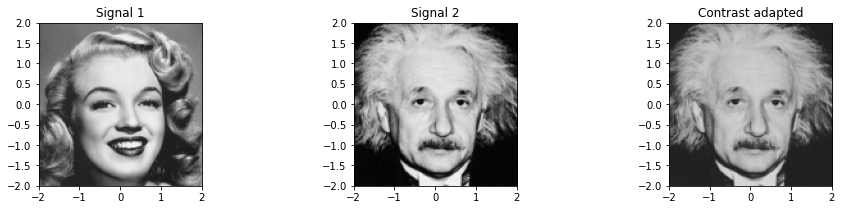

In [99]:
plt.figure(figsize=(16, 3))
plt.subplot(131), plt.imshow(sig1, cmap='gray', extent=extent*2, vmin=-0.5, vmax=0.5), plt.title('Signal 1')
plt.subplot(132), plt.imshow(sig2, cmap='gray', extent=extent*2, vmin=-0.5, vmax=0.5), plt.title('Signal 2')
plt.subplot(133), plt.imshow(sig2a, cmap='gray', extent=extent*2, vmin=-0.5, vmax=0.5), plt.title('Contrast adapted')
plt.show()

**Keep in mind: control your stimuli for equal contrast / power**

#### Summation / Subtraction

According to the principle of linearity, a summation in the image domain corresponds to a summation in the frequency domain.
Let's check this correspondence using two Gabors.

In [54]:
# Version 1: Sum the gratings in the image domain
g_sum1 = g1 + g2

# Version 2: Perform inverse fft of summed frequency spectra
g_sum_fft = g1_fft + g2_fft
g_sum2 = np.real(scipy.fft.ifft2(g_sum_fft))

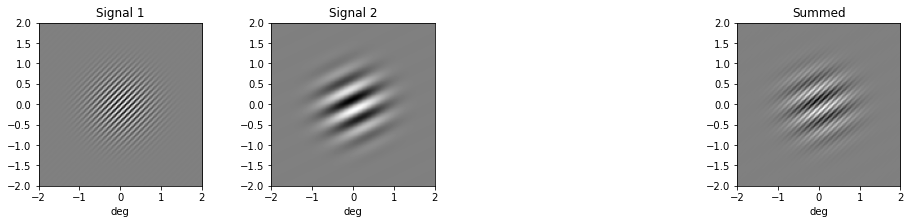

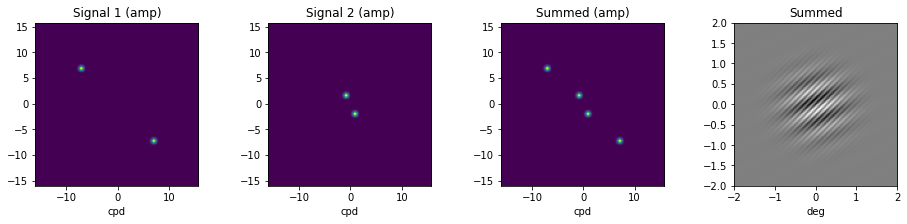

In [55]:
# Plotting
plt.figure(figsize=(16, 3))
plt.subplot(141)
plt.imshow(g1, cmap='gray', extent=extent*2), plt.title('Signal 1'), plt.xlabel('deg')
plt.subplot(142)
plt.imshow(g2, cmap='gray', extent=extent*2), plt.title('Signal 2'), plt.xlabel('deg')
plt.subplot(144)
plt.imshow(g_sum1, cmap='gray', extent=extent*2), plt.title('Summed'), plt.xlabel('deg')
plt.show()

plt.figure(figsize=(16, 3))
plt.subplot(141), plt.imshow(np.abs(scipy.fft.fftshift(g1_fft)), extent=fextent*2)
plt.title('Signal 1 (amp)'), plt.xlabel('cpd')
plt.subplot(142), plt.imshow(np.abs(scipy.fft.fftshift(g2_fft)), extent=fextent*2)
plt.title('Signal 2 (amp)'), plt.xlabel('cpd')
plt.subplot(143), plt.imshow(np.abs(scipy.fft.fftshift(g_sum_fft)), extent=fextent*2)
plt.title('Summed (amp)'), plt.xlabel('cpd')
plt.subplot(144)
plt.imshow(g_sum2, cmap='gray', extent=extent*2), plt.title('Summed'), plt.xlabel('deg')
plt.show()

This holds true for any kind of signal.
To show this, let's visualize how summing two signals looks for natural images.

In [56]:
# Version 1: Sum the gratings in the image domain
im_sum1 = im1 + im2

# Version 2: Sum the frequency spectra and perform inverse fft
im_sum_fft = im1_fft + im2_fft
im_sum2 = np.real(scipy.fft.ifft2(im_sum_fft))

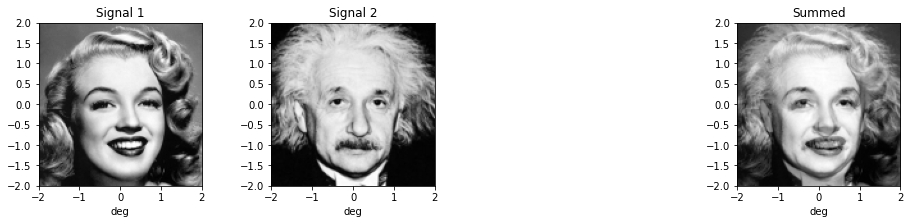

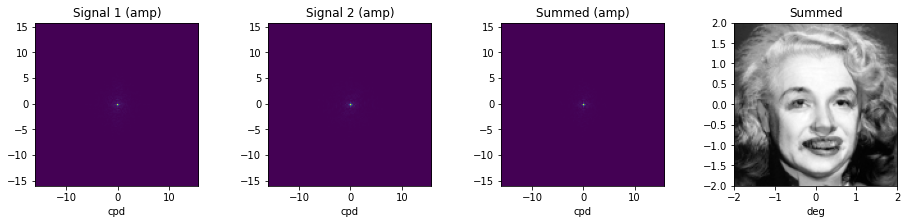

In [57]:
# Plotting
plt.figure(figsize=(16, 3))
plt.subplot(141)
plt.imshow(im1, cmap='gray', extent=extent*2), plt.title('Signal 1'), plt.xlabel('deg')
plt.subplot(142)
plt.imshow(im2, cmap='gray', extent=extent*2), plt.title('Signal 2'), plt.xlabel('deg')
plt.subplot(144)
plt.imshow(im_sum1, cmap='gray', extent=extent*2), plt.title('Summed'), plt.xlabel('deg')
plt.show()

plt.figure(figsize=(16, 3))
plt.subplot(141), plt.imshow(np.abs(scipy.fft.fftshift(im1_fft)), extent=fextent*2)
plt.title('Signal 1 (amp)'), plt.xlabel('cpd')
plt.subplot(142), plt.imshow(np.abs(scipy.fft.fftshift(im2_fft)), extent=fextent*2)
plt.title('Signal 2 (amp)'), plt.xlabel('cpd')
plt.subplot(143), plt.imshow(np.abs(scipy.fft.fftshift(im_sum_fft)), extent=fextent*2)
plt.title('Summed (amp)'), plt.xlabel('cpd')
plt.subplot(144)
plt.imshow(im_sum2, cmap='gray', extent=extent*2), plt.title('Summed'), plt.xlabel('deg')
plt.show()

#### Multiplication (=filtering)

A multiplication in the frequency domain corresponds to a convolution in the image domain and vice versa.
This correspondence is very useful and used a lot in vision sciences, among other things because
multiplications are computationally more convenient than convolutions.

A convolution is the area under the product of two signals.
An example can be seen in the following.
In the example a 5x5 image (or `input`) is convolved with a 3x3 image (or `filter`).
At each location of the output (here: convolved feature), a value is obtained by multiplying
the image and the filter element-wise and summing all values involved in the multiplication.
This procedure is repeated for each element of the input image by sliding the filter over the whole image.

<center>  Animation of a convolution. <a href="https://en.wikipedia.org/wiki/Convolution">wikipedia</a></center> 
<center> <img src="https://upload.wikimedia.org/wikipedia/commons/1/19/2D_Convolution_Animation.gif" width="500"/> </center> 

Let's see how the Fourier transform can help us to speed up this process.
For demonstration purposes, let's use the two gratings that we defined previously, and let's use
a small portion of the grating as filter.

In [58]:
# Generate filter from signal itself
ystart, xstart = int(1.8*ppd), int(1.45*ppd)
fsize = int(0.4*ppd)
filt = im2[ystart:ystart+fsize, xstart:xstart+fsize]

# Filters and/or signal should have a zero-mean, otherwise they respond most to mean intensity
filt = filt - filt.mean()

In [59]:
# Version 1: Convolution in image space
import scipy.signal
im2_filt1 = scipy.signal.convolve2d(im2, filt, 'same')
im2_filt2 = scipy.ndimage.convolve(im2, filt, mode="constant", origin=-1)

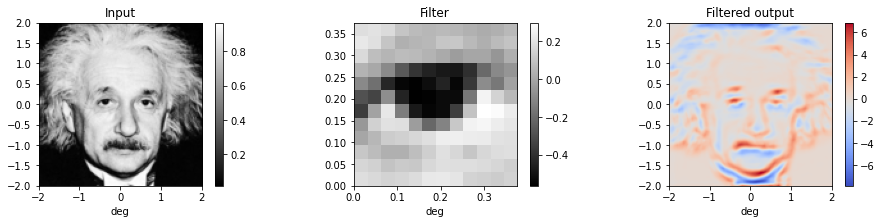

In [60]:
plt.figure(figsize=(16, 3))
plt.subplot(131), plt.imshow(im2, cmap='gray', extent=extent*2)
plt.colorbar(), plt.title('Input'), plt.xlabel('deg')

plt.subplot(132), plt.imshow(filt, cmap='gray', extent=(0, fsize/ppd)*2)
plt.colorbar(), plt.title('Filter'), plt.xlabel('deg')

plt.subplot(133), plt.imshow(im2_filt1, extent=extent*2, cmap='coolwarm')
plt.colorbar(), plt.title('Filtered output'), plt.xlabel('deg')
plt.show()

In [61]:
# Add zero-padding to make the filter the same size as image (needed for multiplication)
filt_pad = np.pad(filt, int(im2.shape[0]/2 - filt.shape[0]/2))

# Perform fft of filter
filt_fft = scipy.fft.fft2(filt_pad)

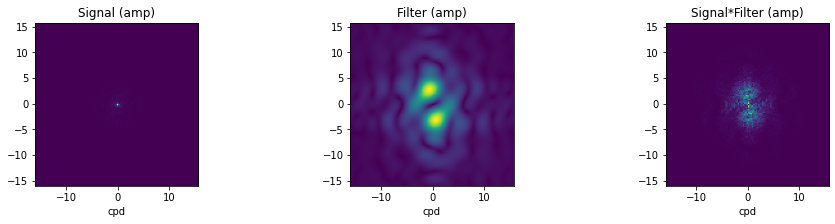

In [62]:
plt.figure(figsize=(16, 3))
plt.subplot(131)
plt.imshow(np.abs(scipy.fft.fftshift(im2_fft)), extent=fextent*2), plt.title('Signal (amp)'), plt.xlabel('cpd')
plt.subplot(132)
plt.imshow(np.abs(scipy.fft.fftshift(filt_fft)), extent=fextent*2), plt.title('Filter (amp)'), plt.xlabel('cpd')
plt.subplot(133)
plt.imshow(np.abs(scipy.fft.fftshift(im2_fft*filt_fft)), extent=fextent*2), plt.title('Signal*Filter (amp)'), plt.xlabel('cpd')
plt.show()

In [63]:
# Version 2: Multiplication in frequency space and ifft
im2_filt2 = np.real(scipy.fft.ifft2(im2_fft * filt_fft))
im2_filt2 = scipy.fft.ifftshift(im2_filt2) # Shift needed because filter origin is assumed to be in image corner

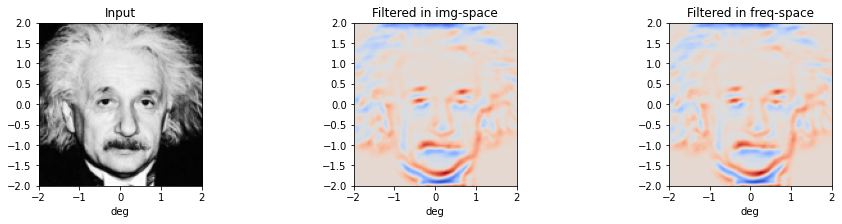

In [64]:
plt.figure(figsize=(16, 3))
plt.subplot(131),plt.imshow(im2, cmap='gray', extent=extent*2), plt.title('Input'), plt.xlabel('deg')

plt.subplot(132), plt.imshow(im2_filt1, extent=extent*2, cmap='coolwarm')
plt.title('Filtered in img-space'), plt.xlabel('deg')

plt.subplot(133), plt.imshow(im2_filt1, extent=extent*2, cmap='coolwarm')
plt.title('Filtered in freq-space'), plt.xlabel('deg')
plt.show()

### Application: Visual filters

1. **Cutting frequency components ("ideal filters")**
2. Low-pass, high-pass, band-pass
3. **Oriented-Difference-of-Gaussians (ODOG-) filters**

#### Cutting frequency components ("ideal filters")
Let's come back to our plaids ...

In [65]:
g1 = grating(2, 0)
g2 = grating(2, np.pi/2)
plaid = g1 + g2

In [66]:
g1_fft = scipy.fft.fft2(g1)
g2_fft = scipy.fft.fft2(g2)
plaid_fft = scipy.fft.fft2(plaid)

In [67]:
g1_amp = np.abs(scipy.fft.fftshift(g1_fft)) / np.size(g1)
g2_amp = np.abs(scipy.fft.fftshift(g2_fft)) / np.size(g1)
plaid_amp = np.abs(scipy.fft.fftshift(plaid_fft)) / np.size(g1)

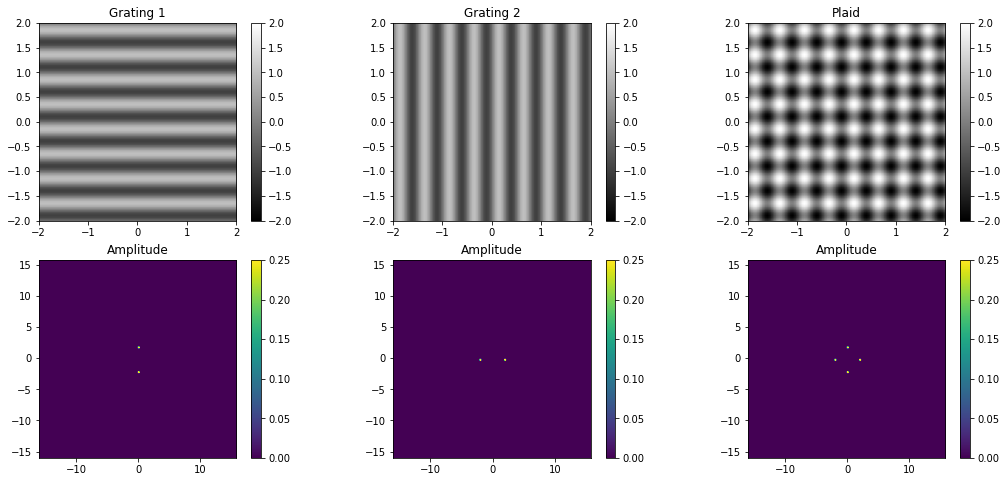

In [68]:
plt.figure(figsize=(18, 8))
plt.subplot(231), plt.imshow(g1, cmap='gray', extent=extent*2, vmin=-2, vmax=2), plt.title('Grating 1'), plt.colorbar()
plt.subplot(232), plt.imshow(g2, cmap='gray', extent=extent*2, vmin=-2, vmax=2), plt.title('Grating 2'), plt.colorbar()
plt.subplot(233), plt.imshow(plaid, cmap='gray', extent=extent*2, vmin=-2, vmax=2), plt.title('Plaid'), plt.colorbar()

plt.subplot(234), plt.imshow(g1_amp, extent=fextent*2, vmin=0, vmax=0.25), plt.title('Amplitude'), plt.colorbar()
plt.subplot(235), plt.imshow(g2_amp, extent=fextent*2, vmin=0, vmax=0.25), plt.title('Amplitude'), plt.colorbar()
plt.subplot(236), plt.imshow(plaid_amp, extent=fextent*2, vmin=0, vmax=0.25), plt.title('Amplitude'), plt.colorbar()
plt.show()

- Imagine a neuron which is only sensitive to horizontal orientations (x-DC).
- We can mimic its response by removing all power for which `fy != 0`

In [69]:
plaid_fft_filt = scipy.fft.fftshift(plaid_fft)                               # Perform fftshift
plaid_fft_filt[fy != 0] = 0                                                  # Remove all non-horizontal information
plaid_filt = np.real(scipy.fft.ifft2(scipy.fft.ifftshift(plaid_fft_filt)))   # inverse fft

In [70]:
plaid_amp_filt = np.abs(plaid_fft_filt) / np.size(plaid)

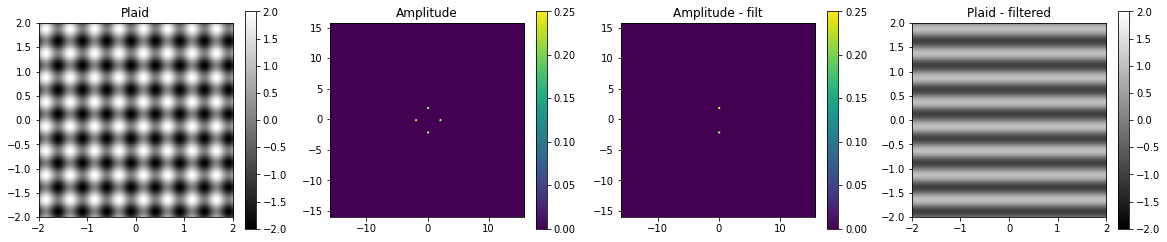

In [75]:
plt.figure(figsize=(20, 4))
plt.subplot(141)
plt.imshow(plaid, cmap='gray', extent=extent*2, vmin=-2, vmax=2), plt.title('Plaid'), plt.colorbar()
plt.subplot(142)
plt.imshow(plaid_amp, extent=fextent*2, vmin=0, vmax=0.25), plt.title('Amplitude'), plt.colorbar()
plt.subplot(143)
plt.imshow(plaid_amp_filt, extent=fextent*2, vmin=0, vmax=0.25), plt.title('Amplitude - filt'), plt.colorbar()
plt.subplot(144)
plt.imshow(plaid_filt, cmap='gray', extent=extent*2, vmin=-2, vmax=2), plt.title('Plaid - filtered'), plt.colorbar()
plt.show()

#### Low-pass, high-pass, band-pass
Ideal-filters are best defined in the frequency domain.
They are called "ideal" filters because they perfectly remove the desired frequency-contents, i.e.
they are 0 at every frequency that should be removed and they are 1 at every frequency that should stay in the signal.

We call a filter `lowpass` if it only removes frequency contents above a certain frequency (i.e. low-frequency information passes).

Conversely, we call a filter `highpass` if it only removes frequency contents below a certain frequency (i.e. high-frequency information passes).

We call a filter `bandpass` if a desired range of frequency contents pass.

When using ideal (i.e. rectangular) filters, be aware of ringing artefacts!
More information: https://en.wikipedia.org/wiki/Ringing_artifacts

In [77]:
def ideal_filter(fx, fy, bounds):
    fxy = np.sqrt(fx**2 + fy**2)
    bandpass = np.ones(fxy.shape)
    if bounds[0] is not None:
        bandpass[fxy<[bounds[0]]] = 0
    if bounds[1] is not None:
        bandpass[fxy>[bounds[1]]] = 0
    return bandpass

def plot_ideal(flow, fhigh):
    ideal = ideal_filter(fx, fy, [flow, fhigh])
    
    plt.figure()
    plt.imshow(ideal, extent=fextent*2), plt.xlabel('deg'), plt.colorbar()
    plt.show()

interactive(plot_ideal, flow=(-1, ppd/2), fhigh=(10, ppd*0.7))

interactive(children=(FloatSlider(value=7.5, description='flow', max=16.0, min=-1.0), FloatSlider(value=16.2, …

We can use the ideal filter to selectively filter out one of the sine-wave gratings that
make up our compound grating.

As we have previously seen, natural images are broadband signals that have power in a wide range of
spatial frequency bands.
We can use the ideal filter to demonstrate what the different frequency contents in the natural image
correspond to.

In [97]:
def ideal_filtering(flow, fhigh):
    ideal = ideal_filter(fx, fy, [flow, fhigh])
    
    # Filter grating
    gfilt_fft = g_sum_fft*scipy.fft.ifftshift(ideal)
    gfilt = np.real(scipy.fft.ifft2(gfilt_fft))
    
    # Filter natural image
    imfilt_fft = im2_fft*scipy.fft.ifftshift(ideal)
    imfilt = np.real(scipy.fft.ifft2(imfilt_fft))
    
    plt.figure(figsize=(18, 8))
    plt.subplot(251), plt.imshow(ideal, extent=fextent*2)
    plt.subplot(252), plt.imshow(g_sum1, cmap='gray', extent=extent*2), plt.title("Input")
    plt.subplot(253), plt.imshow(np.abs(scipy.fft.fftshift(g_sum_fft)), extent=fextent*2), plt.title("Input amplitude")
    plt.subplot(254), plt.imshow(gfilt, cmap='gray', extent=extent*2), plt.title("Output")
    plt.subplot(255), plt.imshow(np.abs(scipy.fft.fftshift(gfilt_fft)), extent=fextent*2), plt.title("Output amplitude")
    plt.subplot(257), plt.imshow(im2, cmap='gray', extent=extent*2)
    plt.subplot(258), plt.imshow(np.abs(scipy.fft.fftshift(im2_fft)), extent=fextent*2)
    plt.subplot(259), plt.imshow(imfilt, cmap='gray', extent=extent*2)
    plt.subplot(2, 5, 10), plt.imshow(np.abs(scipy.fft.fftshift(imfilt_fft)), extent=fextent*2)

interactive(ideal_filtering, flow=(-1, 5.), fhigh=(1, ppd/2))

interactive(children=(FloatSlider(value=2.0, description='flow', max=5.0, min=-1.0), FloatSlider(value=8.5, de…

#### Oriented-Difference-of-Gaussians (ODOG-) filters

A more physiologically plausible filter is the so-called
_Oriented-Difference-of-Gaussian_ or _ODOG_ filter.

ODOG-filters are ...
- localized in space
- tuned to spatial frequency and orientation

In [72]:
def create_odog(xx, yy, sigma_c, sigma_s, orientation):
    # Create center and surround anisotropic Gaussian filters
    center = gaussian2d(xx, yy, sigma=sigma_c, orientation=orientation)
    surround = gaussian2d(xx, yy, sigma=sigma_s, orientation=orientation)

    # Normalize each filter by its total sum
    center = center / center.sum()
    surround = surround / surround.sum()
    return center - surround

In [73]:
def plot_odog(sigma_c, orientation):
    odog = create_odog(xx, yy, (sigma_c, sigma_c), (sigma_c, sigma_c*2), orientation*np.pi/180.)
    plt.figure(figsize=(6, 5))
    plt.imshow(odog, extent=extent*2, cmap='coolwarm')
    plt.colorbar()

interactive(plot_odog, sigma_c=(0.02, 0.2, 0.01), orientation=(0, 180))

interactive(children=(FloatSlider(value=0.11, description='sigma_c', max=0.2, min=0.02, step=0.01), IntSlider(…

Let's see how we can mimic the response behavior of ODOG-like neurons to our plaid stimulus.

For this, let's briefly talk about spatial filtering:

<center>  Spatial filtering. <a href="https://en.wikipedia.org/wiki/Convolution">wikipedia</a></center> 
<center> <img src="https://upload.wikimedia.org/wikipedia/commons/1/19/2D_Convolution_Animation.gif" width="500"/> </center>

Let's convolve our plaid stimulus with our ODOG-filter:

In [102]:
def odog_filtering(sigma_c, orientation):
    odog = create_odog(xx, yy, (sigma_c, sigma_c), (sigma_c, sigma_c*2), orientation*np.pi/180.)
    imfilt = scipy.signal.fftconvolve(plaid, odog, "same")
    
    plt.figure(figsize=(18, 4))
    plt.subplot(141)
    plt.imshow(plaid, cmap='gray', extent=extent*2), plt.title('Plaid')
    plt.subplot(142)
    plt.imshow(odog, cmap='coolwarm', extent=extent*2), plt.title('Filter / Neuron')
    plt.subplot(143)
    plt.imshow(imfilt, cmap='gray', extent=extent*2), plt.title('Neural response')

interactive(odog_filtering, sigma_c=(0.02, 0.2, 0.01), orientation=(0, 90))

interactive(children=(FloatSlider(value=0.11, description='sigma_c', max=0.2, min=0.02, step=0.01), IntSlider(…

ODOG filters show tuning properties similar to simple cells in V1!

## Summary

Part I:
1. Describing 1D signals
2. Frequency representations
3. Limitations of digital signal processing
4. Modifying and filtering signals in frequency domain

Part II:
1. Spectral analysis - why should we care?
2. The Fourier transform in 2d
3. Applications
  - Understanding signals
  - Modifying signals in frequency space
  - Visual filters

Where to go from here? ...
- modeling individual cells
- modeling behavior
- understand early visual perception
- understand & control low-level aspects of your stimuli

The ODOG-model for human brightness perception:

<center> <img src="https://arvo.silverchair-cdn.com/arvo/content_public/journal/jov/934563/i1534-7362-15-14-1-f03.png?Expires=1664618791&Signature=DythXTvuBkjASuSOl54VqzTIMKhQJr31ZPpNAXzDn3H8qyA4xdhRKYkp79Wac~Hron6h2DKBsiZlc5ieWkYZOS49ogBOZirb9Zg7qhyHK-OBAgtO0zd1zXdhkSGvoiKutTFQmNRVUtAGhMpb9hrTTff96Fz8u~6qEj1EJjamOXdcz0gs0ocVQmXI7X1Kysjm6uvpldQ-7sB60wfhJ4lAoVev27bosYi2joaT6GRQJ8rl~6zSXA3mlAMdWg2dnW7POt-idRzR1zox9sWREU-TYYI9bjIgdMnDNu-IZcIIRtSQUFSv6IgA2SvEC5tRec6ZjBP~Yq2Lg-QxwK58ddtkxg__&Key-Pair-Id=APKAIE5G5CRDK6RD3PGA" width="1500"/> </center>

<center>  Image taken from <a href="https://doi.org/10.1167/15.14.1">(Betz et al., 2015)</a></center> 